In [2]:
# Imports
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, f1_score, precision_score, recall_score
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Load the dataframe with all the features we have been able the extract
df_raw = pd.read_csv("all_features.csv")

# Iterative improvements

The goal of this notebook is to shiw the improvements we have witnessed along our journey through this group project. 

# First focus: Extracting an increasing amount of features

Let's compare the performance of a Random forest classifier on the following set of features: 
- EEG features only
- EEG + EOG features
- EEG + EOG + ECG features 

In [4]:
# Load create the dataframes decribed above
EEG_col = [col for col in df_raw.columns if 'EEG' in col]
EOG_col = [col for col in df_raw.columns if 'EOG' in col]
ECG_col = [col for col in df_raw.columns if 'ECG' in col]

df1 = df_raw.drop(columns=EOG_col + ECG_col)    # Contains only  EEG
df2 = df_raw.drop(columns=ECG_col )             # Contains EEG & EOG
df3 = df_raw                                    # Contains features from EEG, EOG & ECG

df_list = [df1,df2,df3]
name_list = ['EEG','EEG + EOG', 'EEG + EOG + ECG']

Dropping 7 features with |corr| > 0.95:
['EEG variance', 'EEG std', 'EEG hjorth_activity', 'EEG hjorth_mobility', 'EEG absolute_power delta', 'EEG relative_power beta', 'EEG power_ratios delta_to_gamma']

=== Classification Report ===
              precision    recall  f1-score   support

           0       0.48      0.05      0.09       298
           1       0.85      0.62      0.72       399
           2       0.60      0.90      0.72       784
           3       0.50      0.02      0.04        47
           4       0.65      0.73      0.69       227

    accuracy                           0.65      1755
   macro avg       0.62      0.46      0.45      1755
weighted avg       0.64      0.65      0.59      1755



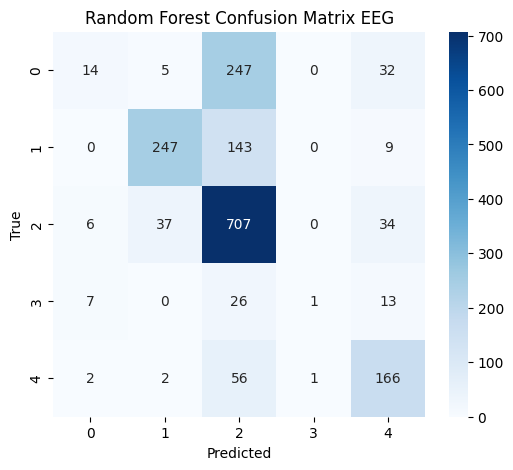

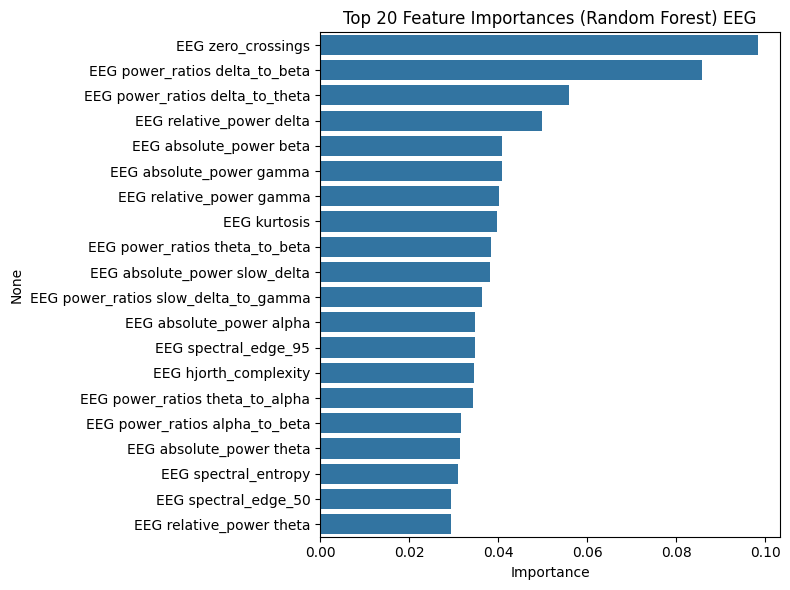

Dropping 13 features with |corr| > 0.95:
['EEG variance', 'EEG std', 'EEG hjorth_activity', 'EEG hjorth_mobility', 'EEG absolute_power delta', 'EEG relative_power beta', 'EEG power_ratios delta_to_gamma', 'EOGL movement_density_mean', 'EOGL signal_std', 'EOGR movement_density_mean', 'EOGR signal_std', 'EOGR power_delta', 'EOGR power_total']

=== Classification Report ===
              precision    recall  f1-score   support

           0       0.89      0.36      0.52       298
           1       0.87      0.48      0.61       399
           2       0.65      0.93      0.77       784
           3       0.00      0.00      0.00        47
           4       0.58      0.74      0.65       227

    accuracy                           0.68      1755
   macro avg       0.60      0.50      0.51      1755
weighted avg       0.72      0.68      0.65      1755



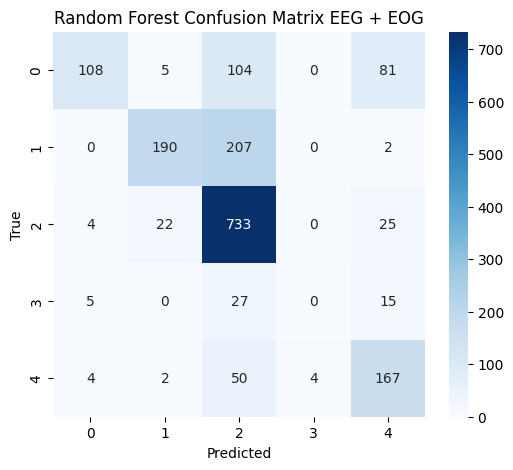

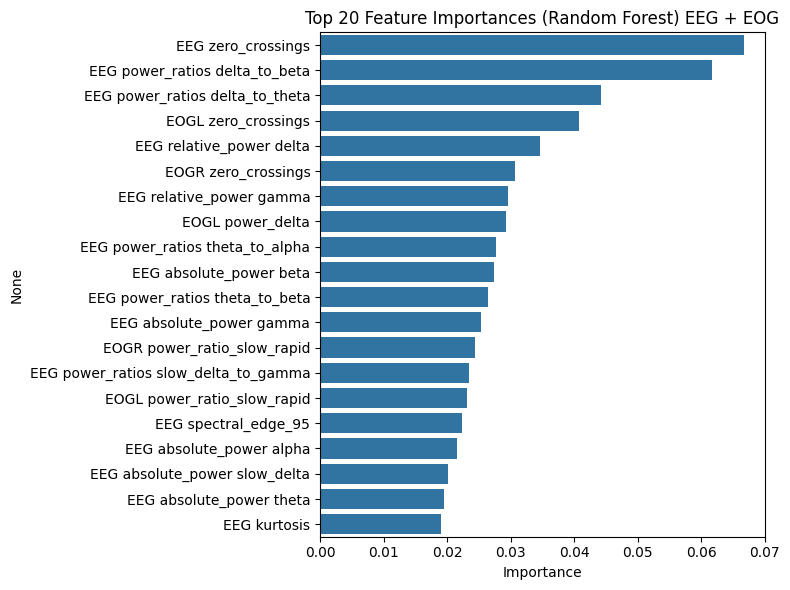

Dropping 23 features with |corr| > 0.95:
['EEG variance', 'EEG std', 'EEG hjorth_activity', 'EEG hjorth_mobility', 'EEG absolute_power delta', 'EEG relative_power beta', 'EEG power_ratios delta_to_gamma', 'EOGL movement_density_mean', 'EOGL signal_std', 'EOGR movement_density_mean', 'EOGR signal_std', 'EOGR power_delta', 'EOGR power_total', 'ECG variance', 'ECG std', 'ECG rms', 'ECG hjorth_activity', 'ECG lf_power', 'ECG hf_power', 'ECG D1_std', 'ECG D1_energy', 'ECG D2_std', 'ECG D2_energy']

=== Classification Report ===
              precision    recall  f1-score   support

           0       0.87      0.36      0.50       298
           1       0.91      0.36      0.52       399
           2       0.64      0.94      0.76       784
           3       0.00      0.00      0.00        47
           4       0.55      0.76      0.63       227

    accuracy                           0.66      1755
   macro avg       0.59      0.48      0.48      1755
weighted avg       0.71      0.66    

c:\Users\m-far\anaconda3\envs\CM2013\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\m-far\anaconda3\envs\CM2013\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\m-far\anaconda3\envs\CM2013\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


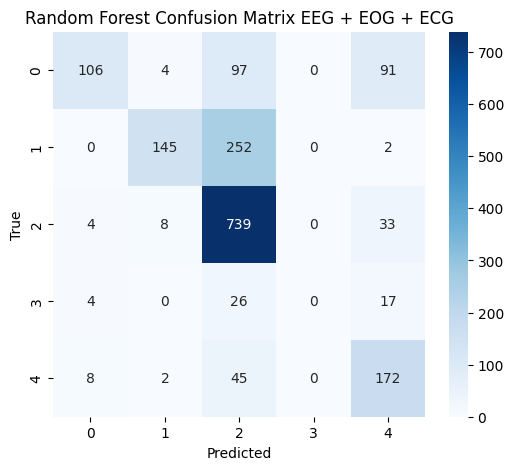

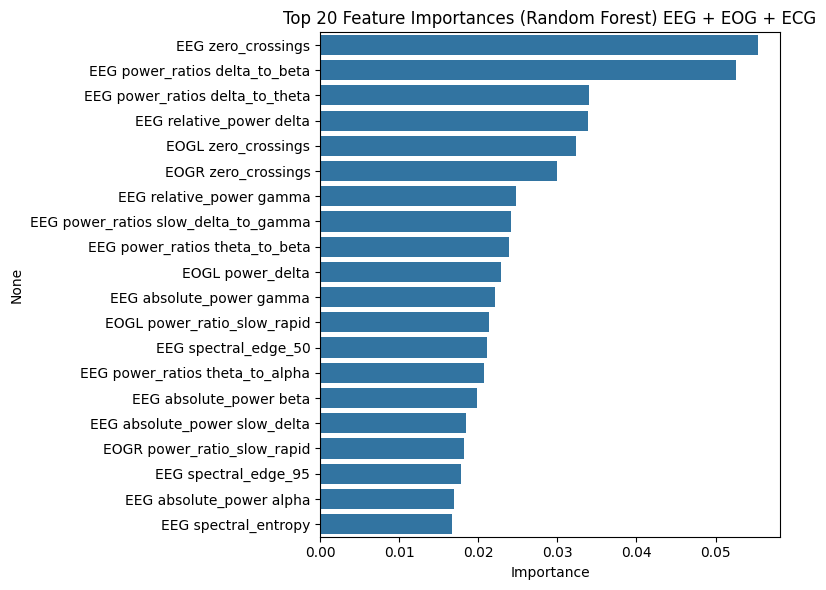

In [5]:
# --- 1) Prepare data ---
# `df` has columns: ['patient_id','epoch_id','label', ... feature columns ...]
id_cols = ['patient_id', 'epoch_id']
label_col = 'label'

results_list = {}
for i, df in enumerate(df_list):
    # Separate out IDs and target
    ids    = df[id_cols]
    y      = df[label_col]
    X_full = df.drop(columns=id_cols + [label_col])

    # --- 2) Drop highly correlated features ---
    def drop_high_corr(X, threshold=0.95):
        corr = X.corr().abs()
        np.fill_diagonal(corr.values, 0)
        to_drop = [col for col in corr.columns if any(corr[col] > threshold)]
        print(f"Dropping {len(to_drop)} features with |corr| > {threshold}:")
        print(to_drop)
        return X.drop(columns=to_drop)

    X_uncorr = drop_high_corr(X_full, threshold=0.95)

    # For now we'll just proceed with X_uncorr:
    X_processed = pd.concat([ids.reset_index(drop=True), y.reset_index(drop=True), X_uncorr], axis=1)

    # Split based on patient_id
    train_patients = [1, 2, 3, 4, 5, 6, 7, 8]
    test_patients  = [9, 10]

    # Create train/test sets
    train_df = X_processed[X_processed['patient_id'].isin(train_patients)]
    test_df  = X_processed[X_processed['patient_id'].isin(test_patients)]

    # Extract features and labels
    X_train = train_df.drop(columns=id_cols + [label_col])
    y_train = train_df['label']
    X_test  = test_df.drop(columns=id_cols + [label_col])
    y_test  = test_df['label']

    # --- 5) Train Random Forest ---
    rf = RandomForestClassifier(
        n_estimators=200,
        max_depth=None,
        min_samples_leaf=2,
        random_state=42,
        n_jobs=-1
    )
    rf.fit(X_train, y_train)

    # --- 6) Evaluate ---
    y_pred_rf = rf.predict(X_test)
    results_list[name_list[i]] = y_pred_rf

    print("\n=== Classification Report ===")
    print(classification_report(y_test, y_pred_rf))

    cm = confusion_matrix(y_test, y_pred_rf)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Random Forest Confusion Matrix ' + name_list[i])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    # --- 7) Feature importances ---
    importances = pd.Series(rf.feature_importances_, index=X_train.columns)
    importances = importances.sort_values(ascending=False).head(20)
    plt.figure(figsize=(8,6))
    sns.barplot(x=importances.values, y=importances.index, orient='h')
    plt.title('Top 20 Feature Importances (Random Forest) ' + name_list[i])
    plt.xlabel('Importance')
    plt.tight_layout()
    plt.show()

c:\Users\m-far\anaconda3\envs\CM2013\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


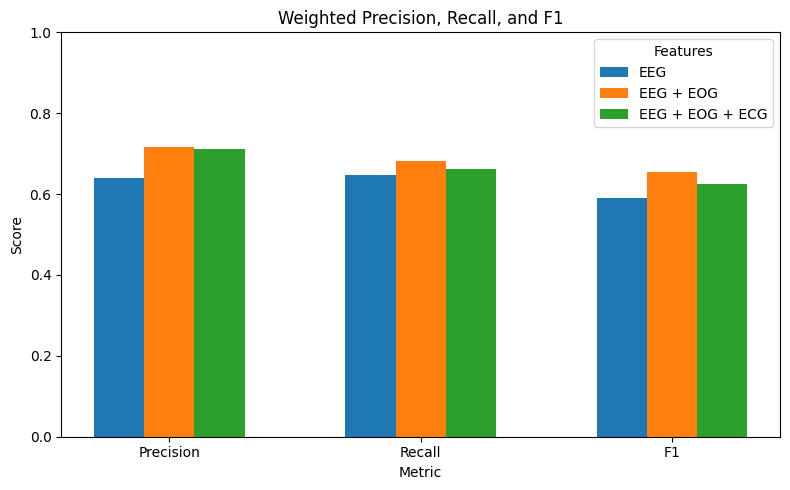

In [6]:
# Compare the evolution of performance when adding new signal features
# 1) Compute weighted metrics for each model
model_preds = results_list

metrics = ['precision', 'recall', 'f1']
results = {}
for name, preds in model_preds.items():
    results[name] = [
        precision_score(y_test, preds, average='weighted'),
        recall_score(   y_test, preds, average='weighted'),
        f1_score(       y_test, preds, average='weighted'),
    ]

# 2) Prepare for plotting
labels = [m.capitalize() for m in metrics]
x = np.arange(len(labels))
width = 0.2  # width of each bar

# 3) Create grouped bar chart
plt.figure(figsize=(8, 5))
for i, (df, scores) in enumerate(results.items()):
    plt.bar(x + (i - 1)*width, scores, width, label=df)

# 4) Labels and legend
plt.xticks(x, labels)
plt.ylim(0, 1)
plt.xlabel('Metric')
plt.ylabel('Score')
plt.title('Weighted Precision, Recall, and F1')
plt.legend(title='Features')
plt.tight_layout()
plt.show()


# The importance of wavelet features
Here we demonstrate the crucial importance of EEG wavelet features training a performant classifier. 

In [7]:
df_no_wav = df_raw.drop(columns=['EEG absolute_power slow_delta', 'EEG absolute_power delta',
       'EEG absolute_power theta', 'EEG absolute_power alpha',
       'EEG absolute_power beta', 'EEG absolute_power gamma',
       'EEG relative_power slow_delta', 'EEG relative_power delta',
       'EEG relative_power theta', 'EEG relative_power alpha',
       'EEG relative_power beta', 'EEG relative_power gamma',
       'EEG power_ratios slow_delta_to_delta',
       'EEG power_ratios delta_to_theta', 'EEG power_ratios theta_to_alpha',
       'EEG power_ratios alpha_to_beta', 'EEG power_ratios delta_to_beta',
       'EEG power_ratios theta_to_beta',
       'EEG power_ratios slow_delta_to_gamma',
       'EEG power_ratios delta_to_gamma', 'EEG spindle_density'])

df1 = df_no_wav   # Contains all features expect EEG wavelets
df2 = df_raw         # Contains all features

df_list = [df1,df2]
name_list = ['no_wavelets', 'wavelets']

Dropping 19 features with |corr| > 0.95:
['EEG variance', 'EEG std', 'EEG hjorth_activity', 'EOGL movement_density_mean', 'EOGL signal_std', 'EOGR movement_density_mean', 'EOGR signal_std', 'EOGR power_delta', 'EOGR power_total', 'ECG variance', 'ECG std', 'ECG rms', 'ECG hjorth_activity', 'ECG lf_power', 'ECG hf_power', 'ECG D1_std', 'ECG D1_energy', 'ECG D2_std', 'ECG D2_energy']

=== Classification Report ===
              precision    recall  f1-score   support

           0       0.75      0.28      0.41       298
           1       0.94      0.20      0.32       399
           2       0.61      0.85      0.71       784
           3       0.00      0.00      0.00        47
           4       0.38      0.78      0.51       227

    accuracy                           0.57      1755
   macro avg       0.54      0.42      0.39      1755
weighted avg       0.66      0.57      0.53      1755



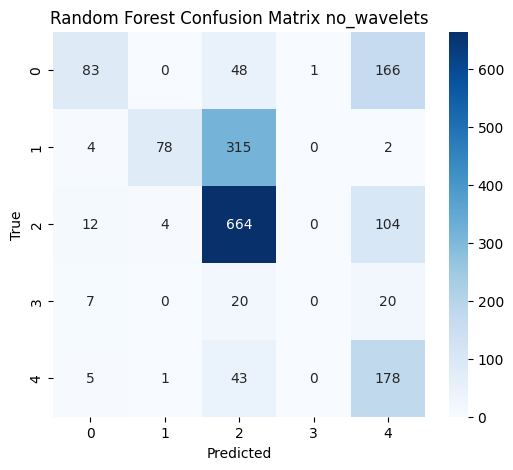

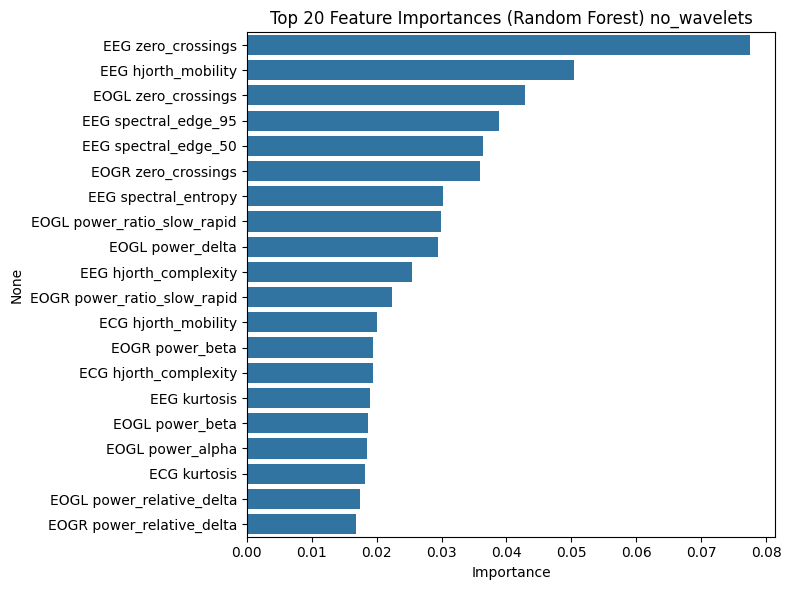

Dropping 23 features with |corr| > 0.95:
['EEG variance', 'EEG std', 'EEG hjorth_activity', 'EEG hjorth_mobility', 'EEG absolute_power delta', 'EEG relative_power beta', 'EEG power_ratios delta_to_gamma', 'EOGL movement_density_mean', 'EOGL signal_std', 'EOGR movement_density_mean', 'EOGR signal_std', 'EOGR power_delta', 'EOGR power_total', 'ECG variance', 'ECG std', 'ECG rms', 'ECG hjorth_activity', 'ECG lf_power', 'ECG hf_power', 'ECG D1_std', 'ECG D1_energy', 'ECG D2_std', 'ECG D2_energy']

=== Classification Report ===
              precision    recall  f1-score   support

           0       0.87      0.36      0.50       298
           1       0.91      0.36      0.52       399
           2       0.64      0.94      0.76       784
           3       0.00      0.00      0.00        47
           4       0.55      0.76      0.63       227

    accuracy                           0.66      1755
   macro avg       0.59      0.48      0.48      1755
weighted avg       0.71      0.66    

c:\Users\m-far\anaconda3\envs\CM2013\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\m-far\anaconda3\envs\CM2013\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\m-far\anaconda3\envs\CM2013\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


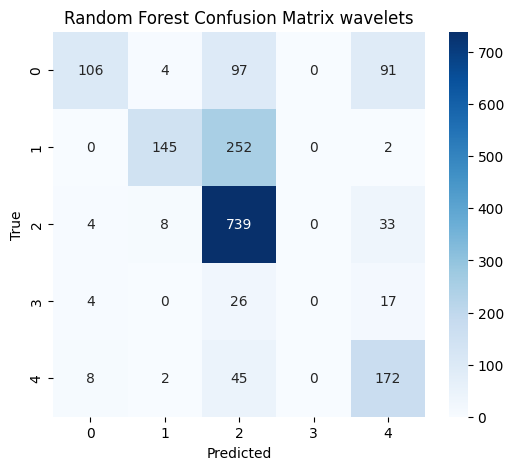

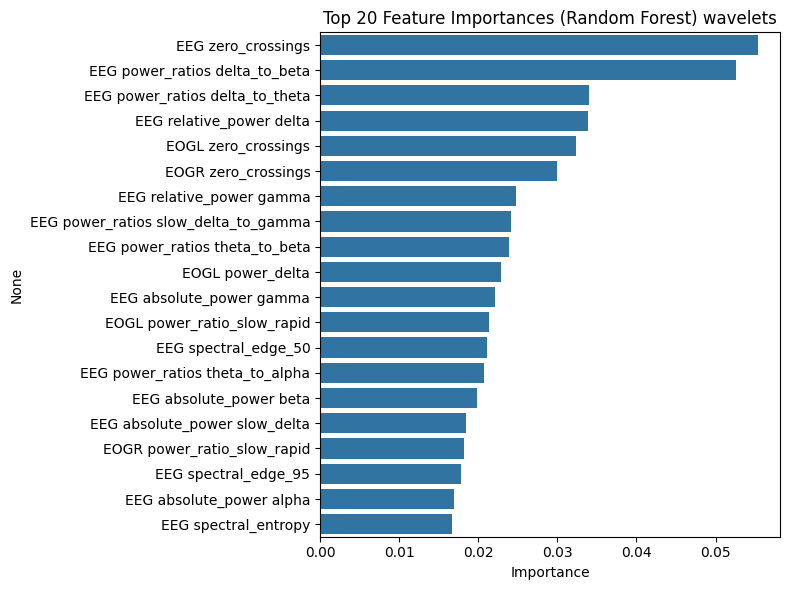

In [8]:
# --- 1) Prepare data ---
# `df` has columns: ['patient_id','epoch_id','label', ... feature columns ...]
id_cols = ['patient_id', 'epoch_id']
label_col = 'label'

results_list = {}
for i, df in enumerate(df_list):
    # Separate out IDs and target
    ids    = df[id_cols]
    y      = df[label_col]
    X_full = df.drop(columns=id_cols + [label_col])

    # --- 2) Drop highly correlated features ---
    def drop_high_corr(X, threshold=0.95):
        corr = X.corr().abs()
        np.fill_diagonal(corr.values, 0)
        to_drop = [col for col in corr.columns if any(corr[col] > threshold)]
        print(f"Dropping {len(to_drop)} features with |corr| > {threshold}:")
        print(to_drop)
        return X.drop(columns=to_drop)

    X_uncorr = drop_high_corr(X_full, threshold=0.95)

    # For now we'll just proceed with X_uncorr:
    X_processed = pd.concat([ids.reset_index(drop=True), y.reset_index(drop=True), X_uncorr], axis=1)

    # Split based on patient_id
    train_patients = [1, 2, 3, 4, 5, 6, 7, 8]
    test_patients  = [9, 10]

    # Create train/test sets
    train_df = X_processed[X_processed['patient_id'].isin(train_patients)]
    test_df  = X_processed[X_processed['patient_id'].isin(test_patients)]

    # Extract features and labels
    X_train = train_df.drop(columns=id_cols + [label_col])
    y_train = train_df['label']
    X_test  = test_df.drop(columns=id_cols + [label_col])
    y_test  = test_df['label']

    # --- 5) Train Random Forest ---
    rf = RandomForestClassifier(
        n_estimators=200,
        max_depth=None,
        min_samples_leaf=2,
        random_state=42,
        n_jobs=-1
    )
    rf.fit(X_train, y_train)

    # --- 6) Evaluate ---
    y_pred_rf = rf.predict(X_test)
    results_list[name_list[i]] = y_pred_rf

    print("\n=== Classification Report ===")
    print(classification_report(y_test, y_pred_rf))

    cm = confusion_matrix(y_test, y_pred_rf)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Random Forest Confusion Matrix ' + name_list[i])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    # --- 7) Feature importances ---
    importances = pd.Series(rf.feature_importances_, index=X_train.columns)
    importances = importances.sort_values(ascending=False).head(20)
    plt.figure(figsize=(8,6))
    sns.barplot(x=importances.values, y=importances.index, orient='h')
    plt.title('Top 20 Feature Importances (Random Forest) ' + name_list[i])
    plt.xlabel('Importance')
    plt.tight_layout()
    plt.show()

c:\Users\m-far\anaconda3\envs\CM2013\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


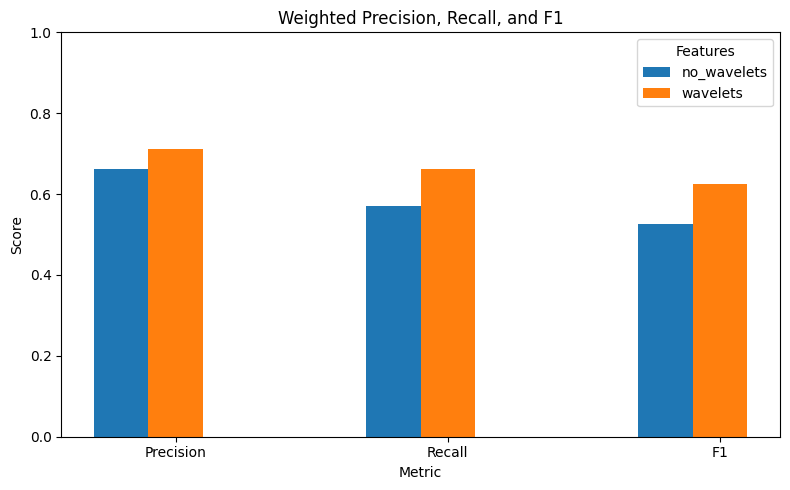

In [9]:
# Compare the evolution of performance when adding new signal features
# 1) Compute weighted metrics for each model
model_preds = results_list

metrics = ['precision', 'recall', 'f1']
results = {}
for name, preds in model_preds.items():
    results[name] = [
        precision_score(y_test, preds, average='weighted'),
        recall_score(   y_test, preds, average='weighted'),
        f1_score(       y_test, preds, average='weighted'),
    ]

# 2) Prepare for plotting
labels = [m.capitalize() for m in metrics]
x = np.arange(len(labels))
width = 0.2  # width of each bar

# 3) Create grouped bar chart
plt.figure(figsize=(8, 5))
for i, (df, scores) in enumerate(results.items()):
    plt.bar(x + (i - 1)*width, scores, width, label=df)

# 4) Labels and legend
plt.xticks(x, labels)
plt.ylim(0, 1)
plt.xlabel('Metric')
plt.ylabel('Score')
plt.title('Weighted Precision, Recall, and F1')
plt.legend(title='Features')
plt.tight_layout()
plt.show()


# The impovements due to the ICA preprocessing

In [10]:
df_no_ICA = pd.read_csv('all_features_no_ICA.csv')

In [11]:
# Load create the dataframes decribed above
EEG_col = [col for col in df_raw.columns if 'EEG' in col]
EOG_col = [col for col in df_raw.columns if 'EOG' in col]
ECG_col = [col for col in df_raw.columns if 'ECG' in col]

df1 = df_raw.drop(columns=ECG_col)    # Contains EEG ICA cleaned signal & EOG signal features
df2 = df_no_ICA.drop(columns=ECG_col)    # Contains EEG not ICA cleaned signal & EOG signal features


df_list = [df1,df2]
name_list = ['ICA cleaned','Not ICA cleaned']

Dropping 13 features with |corr| > 0.95:
['EEG variance', 'EEG std', 'EEG hjorth_activity', 'EEG hjorth_mobility', 'EEG absolute_power delta', 'EEG relative_power beta', 'EEG power_ratios delta_to_gamma', 'EOGL movement_density_mean', 'EOGL signal_std', 'EOGR movement_density_mean', 'EOGR signal_std', 'EOGR power_delta', 'EOGR power_total']

=== Classification Report ===
              precision    recall  f1-score   support

           0       0.89      0.36      0.52       298
           1       0.87      0.48      0.61       399
           2       0.65      0.93      0.77       784
           3       0.00      0.00      0.00        47
           4       0.58      0.74      0.65       227

    accuracy                           0.68      1755
   macro avg       0.60      0.50      0.51      1755
weighted avg       0.72      0.68      0.65      1755



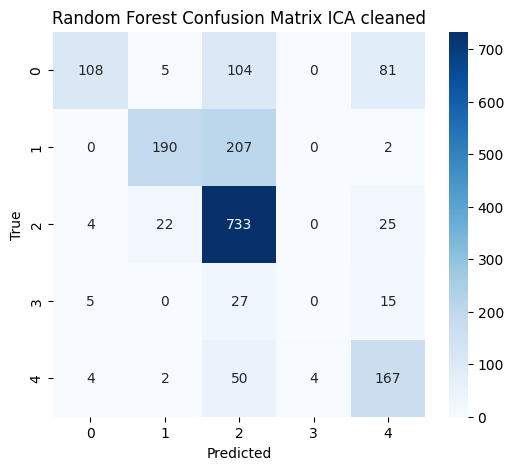

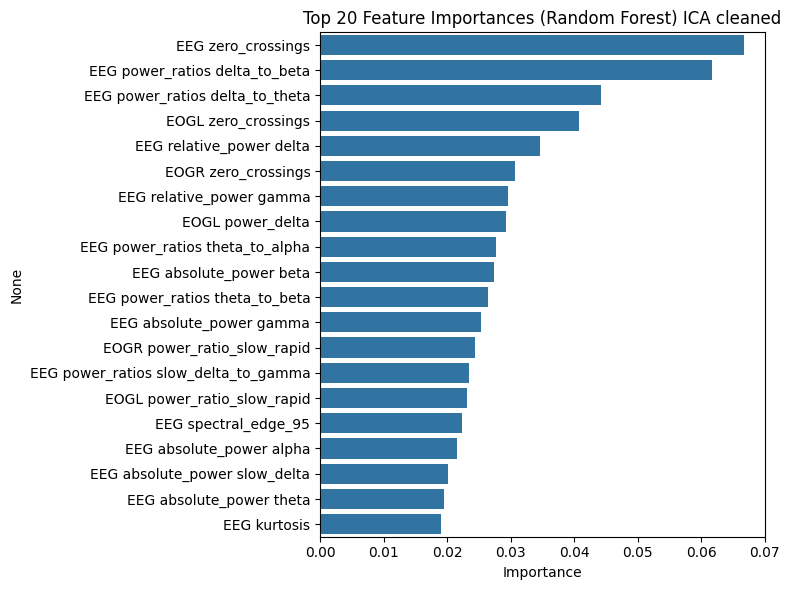

Dropping 16 features with |corr| > 0.95:
['EEG variance', 'EEG std', 'EEG hjorth_activity', 'EEG hjorth_mobility', 'EEG spectral_edge_95', 'EEG absolute_power slow_delta', 'EEG absolute_power delta', 'EEG relative_power beta', 'EEG power_ratios slow_delta_to_gamma', 'EEG power_ratios delta_to_gamma', 'EOGL movement_density_mean', 'EOGL signal_std', 'EOGR movement_density_mean', 'EOGR signal_std', 'EOGR power_delta', 'EOGR power_total']

=== Classification Report ===
              precision    recall  f1-score   support

           0       0.82      0.33      0.47       298
           1       0.86      0.44      0.58       399
           2       0.64      0.93      0.75       784
           3       0.00      0.00      0.00        47
           4       0.53      0.67      0.59       227

    accuracy                           0.66      1755
   macro avg       0.57      0.47      0.48      1755
weighted avg       0.69      0.66      0.63      1755



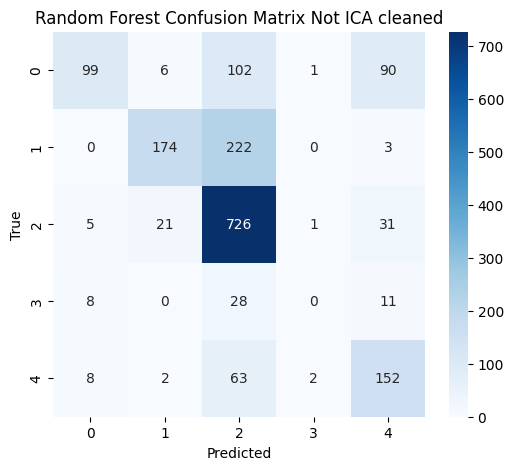

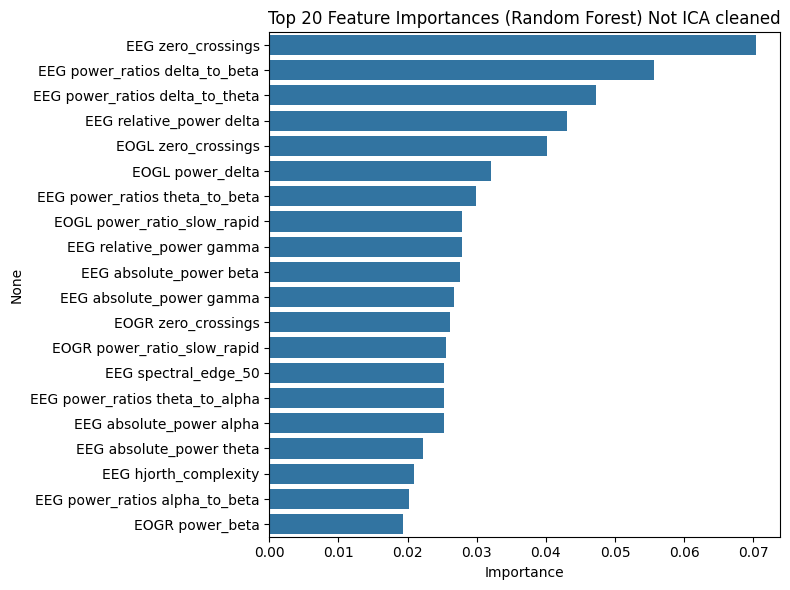

In [12]:
# --- 1) Prepare data ---
# `df` has columns: ['patient_id','epoch_id','label', ... feature columns ...]
id_cols = ['patient_id', 'epoch_id']
label_col = 'label'

results_list = {}
for i, df in enumerate(df_list):
    # Separate out IDs and target
    ids    = df[id_cols]
    y      = df[label_col]
    X_full = df.drop(columns=id_cols + [label_col])

    # --- 2) Drop highly correlated features ---
    def drop_high_corr(X, threshold=0.95):
        corr = X.corr().abs()
        np.fill_diagonal(corr.values, 0)
        to_drop = [col for col in corr.columns if any(corr[col] > threshold)]
        print(f"Dropping {len(to_drop)} features with |corr| > {threshold}:")
        print(to_drop)
        return X.drop(columns=to_drop)

    X_uncorr = drop_high_corr(X_full, threshold=0.95)

    # For now we'll just proceed with X_uncorr:
    X_processed = pd.concat([ids.reset_index(drop=True), y.reset_index(drop=True), X_uncorr], axis=1)

    # Split based on patient_id
    train_patients = [1, 2, 3, 4, 5, 6, 7, 8]
    test_patients  = [9, 10]

    # Create train/test sets
    train_df = X_processed[X_processed['patient_id'].isin(train_patients)]
    test_df  = X_processed[X_processed['patient_id'].isin(test_patients)]

    # Extract features and labels
    X_train = train_df.drop(columns=id_cols + [label_col])
    y_train = train_df['label']
    X_test  = test_df.drop(columns=id_cols + [label_col])
    y_test  = test_df['label']

    # --- 5) Train Random Forest ---
    rf = RandomForestClassifier(
        n_estimators=200,
        max_depth=None,
        min_samples_leaf=2,
        random_state=42,
        n_jobs=-1
    )
    rf.fit(X_train, y_train)

    # --- 6) Evaluate ---
    y_pred_rf = rf.predict(X_test)
    results_list[name_list[i]] = y_pred_rf

    print("\n=== Classification Report ===")
    print(classification_report(y_test, y_pred_rf))

    cm = confusion_matrix(y_test, y_pred_rf)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Random Forest Confusion Matrix ' + name_list[i])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    # --- 7) Feature importances ---
    importances = pd.Series(rf.feature_importances_, index=X_train.columns)
    importances = importances.sort_values(ascending=False).head(20)
    plt.figure(figsize=(8,6))
    sns.barplot(x=importances.values, y=importances.index, orient='h')
    plt.title('Top 20 Feature Importances (Random Forest) ' + name_list[i])
    plt.xlabel('Importance')
    plt.tight_layout()
    plt.show()

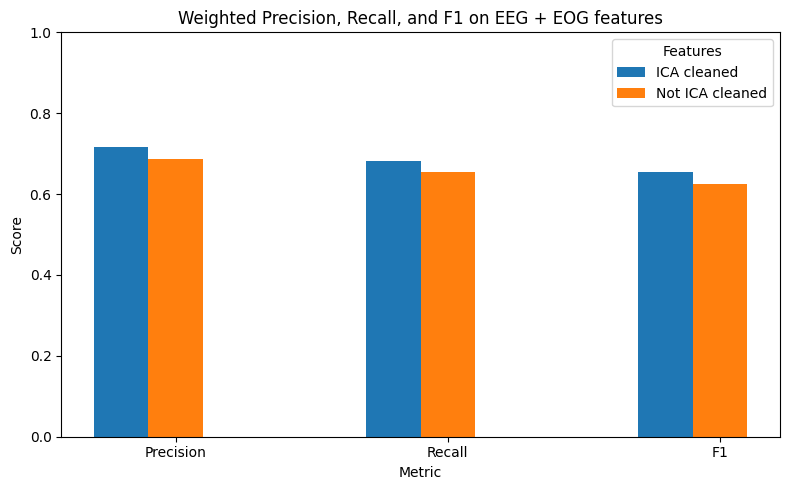

In [14]:
# Compare the evolution of performance when adding new signal features
# 1) Compute weighted metrics for each model
model_preds = results_list

metrics = ['precision', 'recall', 'f1']
results = {}
for name, preds in model_preds.items():
    results[name] = [
        precision_score(y_test, preds, average='weighted'),
        recall_score(   y_test, preds, average='weighted'),
        f1_score(       y_test, preds, average='weighted'),
    ]

# 2) Prepare for plotting
labels = [m.capitalize() for m in metrics]
x = np.arange(len(labels))
width = 0.2  # width of each bar

# 3) Create grouped bar chart
plt.figure(figsize=(8, 5))
for i, (df, scores) in enumerate(results.items()):
    plt.bar(x + (i - 1)*width, scores, width, label=df)

# 4) Labels and legend
plt.xticks(x, labels)
plt.ylim(0, 1)
plt.xlabel('Metric')
plt.ylabel('Score')
plt.title('Weighted Precision, Recall, and F1 on EEG + EOG features')
plt.legend(title='Features')
plt.tight_layout()
plt.show()
